In [35]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, multilabel_confusion_matrix, roc_curve, auc

# Paths
train_dir = "Training"
test_dir = "Testing"
model_name = "MobileNetV2"
img_size = 224
batch_size = 32

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [37]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Fine-tuning

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model_mobilenet = Model(inputs=base_model.input, outputs=output)

model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenet.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 2,552,836 (9.74 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stop, lr_reduce]
)

# Save trained model
model_mobilenet.save(f"{model_name}.h5")

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.7219 - loss: 0.7074 - val_accuracy: 0.3842 - val_loss: 2.2453 - learning_rate: 1.0000e-04
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.9358 - loss: 0.1832 - val_accuracy: 0.5133 - val_loss: 1.7321 - learning_rate: 1.0000e-04
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9636 - loss: 0.1127 - val_accuracy: 0.6125 - val_loss: 1.4847 - learning_rate: 1.0000e-04
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9670 - loss: 0.1018 - val_accuracy: 0.8075 - val_loss: 0.5520 - learning_rate: 1.0000e-04
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.9798 - loss: 0.0647 - val_accuracy: 0.8950 - val_loss: 0.2979 - learning_rate: 1.0000e-04
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.9749 - loss: 0.0645 - val_accuracy: 0.8925 - val_loss: 0.2979 - learning_rate: 1.0000e-04
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - acc

In [39]:
loss, acc = model_mobilenet.evaluate(test_generator)
y_true = test_generator.classes
y_pred_probs = model_mobilenet.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.9478 - loss: 0.1516
38/38 ━━━━━━━━━━━━━━━━━━━━ 26s 621ms/step


In [40]:
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)
mcm = multilabel_confusion_matrix(y_true, y_pred)

tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, multi_class='ovr')

# Print all metrics
print(f"{model_name} Accuracy     : {acc:.4f}")
print(f"Precision              : {cr['macro avg']['precision']:.4f}")
print(f"Recall                 : {cr['macro avg']['recall']:.4f}")
print(f"F1-Score               : {cr['macro avg']['f1-score']:.4f}")
print(f"Specificity            : {specificity:.4f}")
print(f"ROC AUC                : {roc_auc:.4f}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

MobileNetV2 Accuracy     : 0.9450
Precision              : 0.9484
Recall                 : 0.9450
F1-Score               : 0.9452
Specificity            : 0.9817
ROC AUC                : 0.9968
TP: 1134, TN: 3534, FP: 66, FN: 66


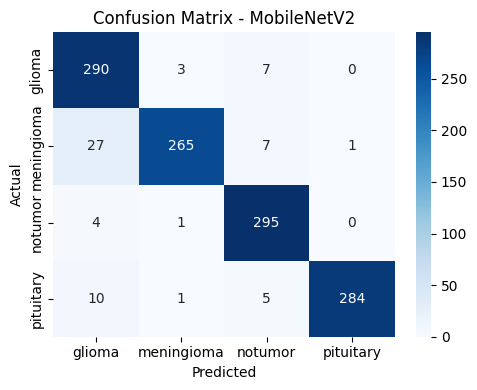

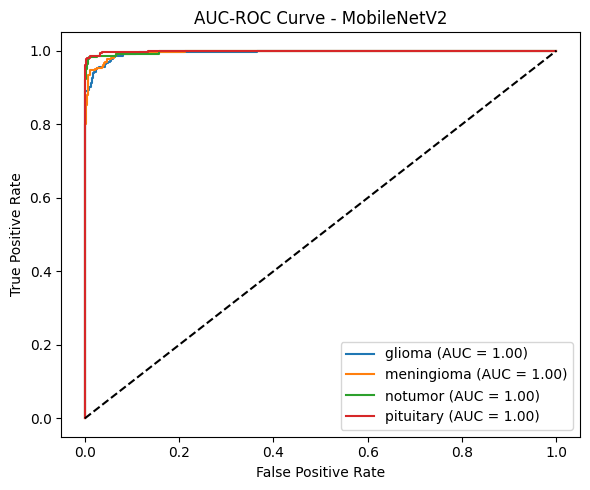

In [41]:
# Confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"conf_matrix_{model_name}.png")
plt.show()

# AUC-ROC Curve
plt.figure(figsize=(6, 5))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true)[:, i], y_pred_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"AUC-ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"auc_roc_{model_name}.png")
plt.show()

In [42]:
result_dict = {
    "Model": [model_name],
    "Accuracy": [acc],
    "Precision": [cr['macro avg']['precision']],
    "Recall": [cr['macro avg']['recall']],
    "Specificity": [specificity],
    "F1-Score": [cr['macro avg']['f1-score']],
    "AUC-ROC": [roc_auc],
    "TP": [tp],
    "TN": [tn],
    "FP": [fp],
    "FN": [fn]
}

results_df = pd.DataFrame(result_dict)
results_file = "all_model_results.csv"

if os.path.exists(results_file):
    results_df.to_csv(results_file, mode='a', index=False, header=False)
else:
    results_df.to_csv(results_file, index=False)

print(f"✅ Results saved to {results_file}")

✅ Results saved to all_model_results.csv
